# Классификатор для TinyImageNet-200

In [1]:
import os
import sys
import multiprocessing


import os
import random
from PIL import Image
import numpy as np
import pandas as pd
from collections import Counter, defaultdict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

torch.manual_seed(21)
np.random.seed(21)
random.seed(21)


if sys.platform == 'darwin':
    multiprocessing.set_start_method('fork', force=True)
# это необходимо, тк DataLoader работает с многопотчностью, которая по дефолту заблокирована на macOS


In [2]:


class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None, class_idx=['n07583066','n07615774','n07871810', 'n09332890']):
        """
        root_dir: путь до папки tiny-imagenet-200
        split: 'train', 'val' или 'test'
        transform: трансформации изображений
        class_idx: классы, что берутся в датасет
        """
        self.root_dir = root_dir
        self.split = split
        self.transform = transform


        with open(os.path.join(root_dir, 'wnids.txt'), 'r') as f:
            self.class_names = [line.strip() for line in f]

        self.class_to_idx = { name: i   for i, name in enumerate(class_idx)}
        self.samples = []
        if split == 'train':
            train_dir = os.path.join(root_dir, 'train')
            for cls in os.listdir(train_dir):
                if cls not in class_idx:
                    continue
                img_dir = os.path.join(train_dir, cls, 'images')
                if not os.path.exists(img_dir):
                    continue
                for img_name in os.listdir(img_dir):
                    img_path = os.path.join(img_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        elif split == 'val':
            val_dir = os.path.join(root_dir, 'val', 'images')
            anno_path = os.path.join(root_dir, 'val', 'val_annotations.txt')

            label_map = {}
            with open(anno_path, 'r') as f:
                for line in f:
                    img_name, cls, *_ = line.strip().split('\t')
                    label_map[img_name] = cls

            for img_name in os.listdir(val_dir):
                cls = label_map.get(img_name)
                if cls not in class_idx:
                    continue
                if cls:
                    img_path = os.path.join(val_dir, img_name)
                    label = self.class_to_idx[cls]
                    self.samples.append((img_path, label))

        else:
            test_dir = os.path.join(root_dir, 'test', 'images')
            for img_name in os.listdir(test_dir):
                img_path = os.path.join(test_dir, img_name)
                self.samples.append((img_path, -1))  # тест без меток

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label


In [3]:
def read_file_to_dict_basic(filename, class_id):
    result = {}
    with open(filename, 'r', encoding='utf-8') as file:
        cnt = 0
        for line in file:
            line = line.strip()  # Убираем лишние пробелы и переносы
            if line:  
                parts = line.split('\t') 
                if len(parts) >= 2:
                    key = parts[0]
                    if key not in class_id:
                        continue
                    value = parts[1]
                    result[cnt] = value
                    cnt +=1
    return result


In [4]:
root = './../data/tiny-imagenet-200'


train_transform = transforms.Compose([
    transforms.Resize((160, 160)),                    
    transforms.RandomResizedCrop(124, scale=(0.7, 1.0)),  
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(19),
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.3, hue=0.1),
    transforms.ToTensor(),                     
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((124, 124)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = val_transform


# Создание разделенных датасетов
train_dataset = TinyImageNetDataset(
    root_dir=root,
    split='train',
    transform=train_transform
)


test_dataset = TinyImageNetDataset(
    root_dir=root,
    split='val', 
    transform=test_transform
)

print(f"Train: {len(train_dataset)} samples")
print(f"Test: {len(test_dataset)} samples")


Train: 2000 samples
Test: 200 samples


# Стратификация и разделение train на train / val

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
X, y = [x for x, _ in train_dataset], [y for _ , y in train_dataset]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
train_idx, val_idx = next(sss.split(X, y))

# Создаем стратифицированные разделения
train_split_stratified = [( X[i], y[i]) for i in train_idx]
val_split_stratified = [( X[i], y[i]) for i in val_idx]

print(f" Стратифицированное разделение на валидации:")
val_counts = Counter([y for _, y in val_split_stratified])
for cls in sorted(val_counts.keys()):
    print(f"  Класс {cls}: {val_counts[cls]} samples")


print(f" Стратифицированное разделение на трейне:")
train_counts = Counter([y for _, y in train_split_stratified])

for cls in sorted(train_counts.keys()):
    print(f"  Класс {cls}: {train_counts[cls]} samples")

 Стратифицированное разделение на валидации:
  Класс 0: 150 samples
  Класс 1: 150 samples
  Класс 2: 150 samples
  Класс 3: 150 samples
 Стратифицированное разделение на трейне:
  Класс 0: 350 samples
  Класс 1: 350 samples
  Класс 2: 350 samples
  Класс 3: 350 samples


In [6]:
train_loader = DataLoader(train_split_stratified, batch_size=524, shuffle=True, num_workers=0)
val_loader = DataLoader(val_split_stratified, batch_size=600, shuffle=True, num_workers=0)


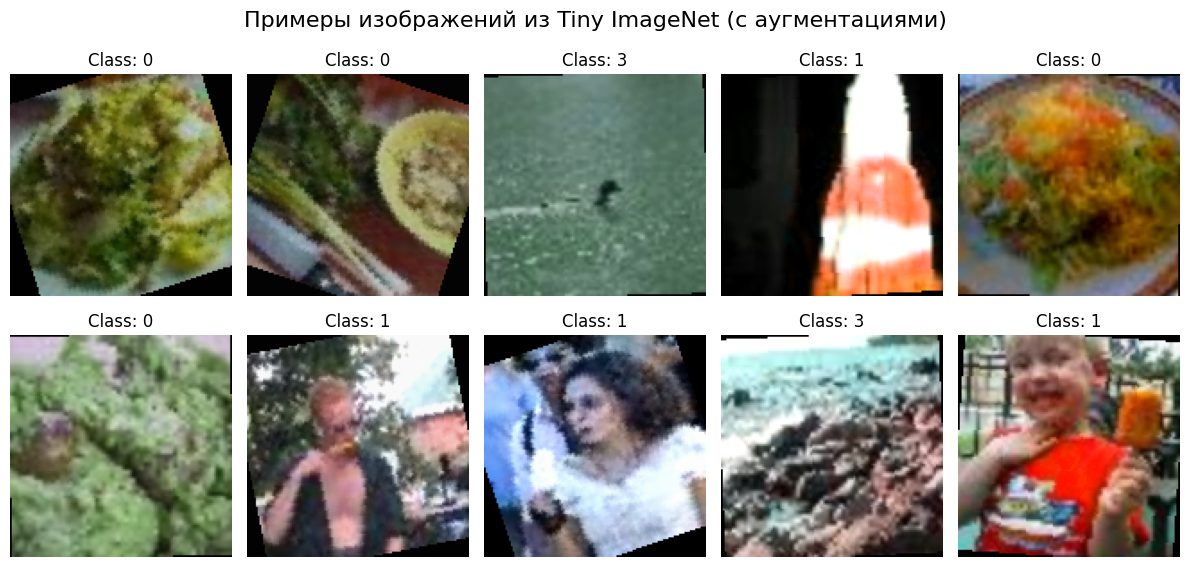

Размер батча: torch.Size([10, 3, 124, 124])
Диапазон значений: [-2.118, 2.640]
Метки классов: [0, 0, 3, 1, 0, 0, 1, 1, 3, 1]
Всего классов в датасете: 4
Названия классов: dict_keys(['n07583066', 'n07615774', 'n07871810', 'n09332890'])


In [7]:
images, labels = next(iter(train_loader))

images, labels = images[:10], labels[:10]
# за один getitem выходит 1 batch

def denormalize(img_tensor):
    """Вернём изображение из нормализованного диапазона в [0,1]"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    img = img_tensor.permute(1, 2, 0) * std + mean
    return img.clamp(0, 1)

images_vis = images.permute(0, 2, 3, 1)

images_vis = torch.stack([denormalize(img) for img in images])

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images_vis[i])
    plt.title(f"Class: {labels[i].item()}")
    plt.axis('off')

plt.suptitle("Примеры изображений из Tiny ImageNet (с аугментациями)", fontsize=16)
plt.tight_layout()
plt.show()

print(f"Размер батча: {images.shape}")
print(f"Диапазон значений: [{images.min():.3f}, {images.max():.3f}]")
print(f"Метки классов: {labels.tolist()}")
print(f"Всего классов в датасете: {len(train_dataset.class_to_idx)}")
print(f"Названия классов: {train_dataset.class_to_idx.keys()}")

# Собственная нейросеть

In [8]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, out_channels, stride=1):
        super().__init__()
        
        # 1x1 convolution - сжатие (bottleneck)
        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, 1)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)
        
        # 3x3 convolution
        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, 3, 
                              stride=stride, padding=1)
        
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)
        
        # 1x1 convolution - расширение
        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, 1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)
        
        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        identity = self.shortcut(x)
        
        # Bottleneck path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Residual connection
        out += identity
        out = self.relu(out)
        
        return out



class SimpleNetEncoder(nn.Module):
    
    def __init__(self, num_classes=4):
        super().__init__()
        
        self.stage0 = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
        self.stage1 = BottleneckBlock(16, 8, 32, stride=2)
        self.stage2 = BottleneckBlock(32, 16, 64, stride=2)  
        self.stage3 = BottleneckBlock(64, 32, 128, stride=2)
        
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.stage0(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        
        x = self.gap(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

In [9]:
def train_epoch(model, train_loader, optimizer, criterion, device ):
    """
    Функция для одного эпоха обучения
    
    Args:
        model: модель для обучения
        train_loader: DataLoader с тренировочными данными
        optimizer: оптимизатор
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        train_loss: средняя потеря за эпох
        train_acc: средняя точность за эпох
    """
    model.train()  # Переводим модель в режим обучения
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    

    pbar = tqdm(train_loader, desc="Training")
    
    for batch_idx, (data, target) in enumerate(pbar):
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item() * target.size(0)
        y_pred = torch.argmax(outputs,dim=-1)
        correct += torch.sum(y_pred == target)
        loss.backward()
        optimizer.step()
        total += target.size(0)
        pbar.set_postfix({
            'Loss per batch': f'{loss.item():.4f}',
            'Acc per batch': f'{torch.sum(y_pred == target) * 100/ target.size(0):.1f}'
        })
    return running_loss/total, correct/total
    

def validate_epoch(model, val_loader, criterion, device):
    """
    Функция для валидации модели
    
    Args:
        model: модель для валидации
        val_loader: DataLoader с валидационными данными
        criterion: функция потерь
        device: устройство (cpu/cuda)
    
    Returns:
        val_loss: средняя потеря на валидации
        val_acc: средняя точность на валидации
    """
    model.eval()  # Переводим модель в режим оценки
    
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(val_loader, desc="Validation")
    
    with torch.no_grad():  # Отключаем вычисление градиентов
        running_loss = 0.0
        correct = 0
        for batch_idx, (data, target) in enumerate(pbar):
            data, target = data.to(device), target.to(device)
            total +=  target.size(0)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item() * target.size(0)
            y_pred = torch.argmax(outputs, dim=-1)
            correct += torch.sum(y_pred == target)
            pbar.set_postfix({
            'Loss per batch': f'{loss.item():.4f}',
            'Acc per batch': f'{torch.sum(y_pred == target) * 100/ target.size(0):.2f}'
        })
    return running_loss/total, correct/total




def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=10, save_path = './training_results/1.Classification'):
    best_model_path = os.path.join(save_path, 'best_model.pth')
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    model = model.to(device)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f" Эпоха {epoch+1}/{num_epochs}")
        
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device )
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc * 100:.2f}%")
        print(f" Val Loss: {val_loss:.4f}, Val Acc: {val_acc * 100:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f" Сохранена лучшая модель с точностью {val_acc * 100:.2f}%")

    return history

In [10]:
model = SimpleNet()
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('----------------------------------')
print(f" Всего параметров: {total_params:,}")
print(f" Обучаемых параметров: {trainable_params:,}")

SimpleNet(
  (conv): Conv2d(3, 256, kernel_size=(3, 3), stride=(2, 2), padding=(3, 3))
  (bottle1): BottleneckBlock(
    (conv1): Conv2d(256, 312, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(312, 312, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(312, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(312, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn3): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv2d(256, 50, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU(inplace=True)
  )
  (relu): ReLU()
  (gap): AdaptiveAvgPool2d(output_size=(1, 1))
  (bn): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [10]:
model = SimpleNetEncoder()
criterion = nn.CrossEntropyLoss()
from torch.optim import AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=torch.device('cpu'),
    num_epochs=40
)

 Эпоха 1/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.61s/it, Loss per batch=1.3860, Acc per batch=25.17]


 Train Loss: 1.3437, Train Acc: 33.50%
 Val Loss: 1.3860, Val Acc: 25.17%
 Сохранена лучшая модель с точностью 25.17%
 Эпоха 2/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.58s/it, Loss per batch=1.3813, Acc per batch=27.00]


 Train Loss: 1.1597, Train Acc: 54.00%
 Val Loss: 1.3813, Val Acc: 27.00%
 Сохранена лучшая модель с точностью 27.00%
 Эпоха 3/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.65s/it, Loss per batch=1.3678, Acc per batch=27.83]


 Train Loss: 1.0430, Train Acc: 56.57%
 Val Loss: 1.3678, Val Acc: 27.83%
 Сохранена лучшая модель с точностью 27.83%
 Эпоха 4/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, Loss per batch=1.3275, Acc per batch=36.50]


 Train Loss: 0.9674, Train Acc: 58.43%
 Val Loss: 1.3275, Val Acc: 36.50%
 Сохранена лучшая модель с точностью 36.50%
 Эпоха 5/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, Loss per batch=1.2492, Acc per batch=51.33]


 Train Loss: 0.9295, Train Acc: 59.71%
 Val Loss: 1.2492, Val Acc: 51.33%
 Сохранена лучшая модель с точностью 51.33%
 Эпоха 6/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss per batch=1.1449, Acc per batch=59.17]


 Train Loss: 0.9024, Train Acc: 60.86%
 Val Loss: 1.1449, Val Acc: 59.17%
 Сохранена лучшая модель с точностью 59.17%
 Эпоха 7/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, Loss per batch=1.0563, Acc per batch=61.67]


 Train Loss: 0.8845, Train Acc: 61.86%
 Val Loss: 1.0563, Val Acc: 61.67%
 Сохранена лучшая модель с точностью 61.67%
 Эпоха 8/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, Loss per batch=0.9954, Acc per batch=62.17]


 Train Loss: 0.8683, Train Acc: 62.00%
 Val Loss: 0.9954, Val Acc: 62.17%
 Сохранена лучшая модель с точностью 62.17%
 Эпоха 9/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, Loss per batch=0.9559, Acc per batch=62.83]


 Train Loss: 0.8547, Train Acc: 62.93%
 Val Loss: 0.9559, Val Acc: 62.83%
 Сохранена лучшая модель с точностью 62.83%
 Эпоха 10/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.74s/it, Loss per batch=0.9306, Acc per batch=63.50]


 Train Loss: 0.8428, Train Acc: 63.86%
 Val Loss: 0.9306, Val Acc: 63.50%
 Сохранена лучшая модель с точностью 63.50%
 Эпоха 11/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.9205, Acc per batch=61.67]


 Train Loss: 0.8311, Train Acc: 63.29%
 Val Loss: 0.9205, Val Acc: 61.67%
 Эпоха 12/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.9088, Acc per batch=62.33]


 Train Loss: 0.8220, Train Acc: 64.07%
 Val Loss: 0.9088, Val Acc: 62.33%
 Эпоха 13/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, Loss per batch=0.9043, Acc per batch=62.33]


 Train Loss: 0.8142, Train Acc: 64.57%
 Val Loss: 0.9043, Val Acc: 62.33%
 Эпоха 14/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.8880, Acc per batch=62.17]


 Train Loss: 0.7987, Train Acc: 65.07%
 Val Loss: 0.8880, Val Acc: 62.17%
 Эпоха 15/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss per batch=0.8813, Acc per batch=62.50]


 Train Loss: 0.7871, Train Acc: 66.07%
 Val Loss: 0.8813, Val Acc: 62.50%
 Эпоха 16/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, Loss per batch=0.8996, Acc per batch=62.83]


 Train Loss: 0.7784, Train Acc: 66.43%
 Val Loss: 0.8996, Val Acc: 62.83%
 Эпоха 17/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, Loss per batch=0.8762, Acc per batch=63.50]


 Train Loss: 0.7637, Train Acc: 67.43%
 Val Loss: 0.8762, Val Acc: 63.50%
 Эпоха 18/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.88s/it, Loss per batch=0.9127, Acc per batch=62.50]


 Train Loss: 0.7572, Train Acc: 67.36%
 Val Loss: 0.9127, Val Acc: 62.50%
 Эпоха 19/40


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.31s/it, Loss per batch=0.8630, Acc per batch=63.50]


 Train Loss: 0.7428, Train Acc: 69.14%
 Val Loss: 0.8630, Val Acc: 63.50%
 Эпоха 20/40


Validation: 100%|██████████| 1/1 [00:03<00:00,  3.05s/it, Loss per batch=0.8520, Acc per batch=64.50]


 Train Loss: 0.7293, Train Acc: 69.64%
 Val Loss: 0.8520, Val Acc: 64.50%
 Сохранена лучшая модель с точностью 64.50%
 Эпоха 21/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.8375, Acc per batch=65.50]


 Train Loss: 0.7297, Train Acc: 69.50%
 Val Loss: 0.8375, Val Acc: 65.50%
 Сохранена лучшая модель с точностью 65.50%
 Эпоха 22/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.77s/it, Loss per batch=0.8685, Acc per batch=64.67]


 Train Loss: 0.7117, Train Acc: 69.57%
 Val Loss: 0.8685, Val Acc: 64.67%
 Эпоха 23/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, Loss per batch=0.8367, Acc per batch=65.83]


 Train Loss: 0.7023, Train Acc: 69.86%
 Val Loss: 0.8367, Val Acc: 65.83%
 Сохранена лучшая модель с точностью 65.83%
 Эпоха 24/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, Loss per batch=0.8059, Acc per batch=67.50]


 Train Loss: 0.7043, Train Acc: 70.79%
 Val Loss: 0.8059, Val Acc: 67.50%
 Сохранена лучшая модель с точностью 67.50%
 Эпоха 25/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, Loss per batch=0.8279, Acc per batch=67.00]


 Train Loss: 0.6839, Train Acc: 71.21%
 Val Loss: 0.8279, Val Acc: 67.00%
 Эпоха 26/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.8174, Acc per batch=65.00]


 Train Loss: 0.6745, Train Acc: 72.36%
 Val Loss: 0.8174, Val Acc: 65.00%
 Эпоха 27/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss per batch=0.8316, Acc per batch=67.17]


 Train Loss: 0.6593, Train Acc: 72.71%
 Val Loss: 0.8316, Val Acc: 67.17%
 Эпоха 28/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it, Loss per batch=0.7896, Acc per batch=67.50]


 Train Loss: 0.6545, Train Acc: 73.00%
 Val Loss: 0.7896, Val Acc: 67.50%
 Эпоха 29/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.8304, Acc per batch=66.33]


 Train Loss: 0.6477, Train Acc: 73.43%
 Val Loss: 0.8304, Val Acc: 66.33%
 Эпоха 30/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, Loss per batch=0.7836, Acc per batch=68.00]


 Train Loss: 0.6379, Train Acc: 74.21%
 Val Loss: 0.7836, Val Acc: 68.00%
 Сохранена лучшая модель с точностью 68.00%
 Эпоха 31/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss per batch=0.7830, Acc per batch=67.33]


 Train Loss: 0.6256, Train Acc: 75.00%
 Val Loss: 0.7830, Val Acc: 67.33%
 Эпоха 32/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss per batch=0.7804, Acc per batch=68.50]


 Train Loss: 0.6183, Train Acc: 74.36%
 Val Loss: 0.7804, Val Acc: 68.50%
 Сохранена лучшая модель с точностью 68.50%
 Эпоха 33/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, Loss per batch=0.7758, Acc per batch=70.00]


 Train Loss: 0.6151, Train Acc: 73.64%
 Val Loss: 0.7758, Val Acc: 70.00%
 Сохранена лучшая модель с точностью 70.00%
 Эпоха 34/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, Loss per batch=0.8280, Acc per batch=65.50]


 Train Loss: 0.6155, Train Acc: 75.00%
 Val Loss: 0.8280, Val Acc: 65.50%
 Эпоха 35/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.54s/it, Loss per batch=0.7848, Acc per batch=68.50]


 Train Loss: 0.6003, Train Acc: 75.21%
 Val Loss: 0.7848, Val Acc: 68.50%
 Эпоха 36/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.46s/it, Loss per batch=0.7746, Acc per batch=70.00]


 Train Loss: 0.5958, Train Acc: 75.36%
 Val Loss: 0.7746, Val Acc: 70.00%
 Эпоха 37/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.60s/it, Loss per batch=0.8115, Acc per batch=67.50]


 Train Loss: 0.5790, Train Acc: 76.93%
 Val Loss: 0.8115, Val Acc: 67.50%
 Эпоха 38/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.47s/it, Loss per batch=0.7726, Acc per batch=69.00]


 Train Loss: 0.5788, Train Acc: 76.79%
 Val Loss: 0.7726, Val Acc: 69.00%
 Эпоха 39/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.48s/it, Loss per batch=0.7761, Acc per batch=70.83]


 Train Loss: 0.5740, Train Acc: 77.00%
 Val Loss: 0.7761, Val Acc: 70.83%
 Сохранена лучшая модель с точностью 70.83%
 Эпоха 40/40


Validation: 100%|██████████| 1/1 [00:02<00:00,  2.53s/it, Loss per batch=0.7922, Acc per batch=71.17]

 Train Loss: 0.5737, Train Acc: 76.29%
 Val Loss: 0.7922, Val Acc: 71.17%
 Сохранена лучшая модель с точностью 71.17%


История сохранена в ./training_results/1.Classification/SimpleNetEncoder


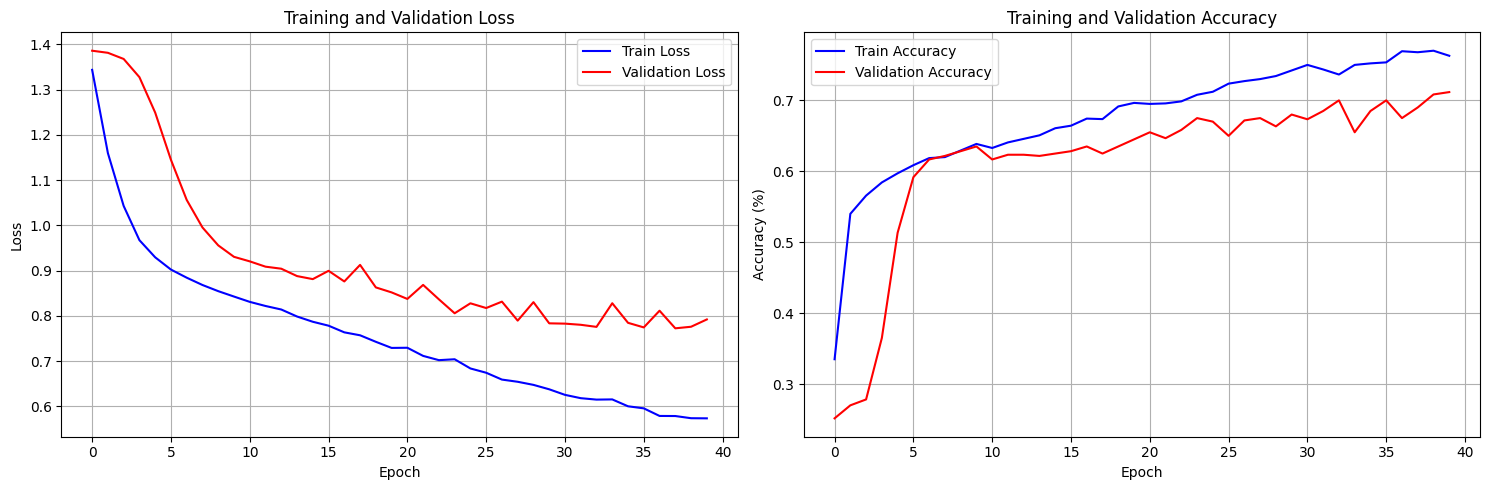

Результаты сохранены в папку: ./training_results/1.Classification/SimpleNetEncoder


In [11]:
def plot_training_history(history, save_dir="./training_results", experiment = '1.Classification/SimpleNetEncoder', var=None):
    
    save_path = os.path.join(save_dir,experiment,var) if var is not None else os.path.join(save_dir,experiment) 
    os.makedirs(save_path, exist_ok=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    list_to_np = lambda x:  [el.detach().numpy() for el in x]
    #
    print(f'История сохранена в {save_path}')
    #
    ax1.plot(history['train_loss'], label='Train Loss', color='blue')
    ax1.plot(history['val_loss'], label='Validation Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    plt.tight_layout()


    ax2.plot(list_to_np(history['train_acc']), label='Train Accuracy', color='blue')
    ax2.plot(list_to_np(history['val_acc']), label='Validation Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'loss_accuracy_plot.png'), dpi=300, bbox_inches='tight')
    plt.show()

    history_file = os.path.join(save_path, 'training_history.txt')
    with open(history_file, 'w') as f:
        f.write("Epoch\tTrain_Loss\tVal_Loss\tTrain_Acc\tVal_Acc\n")
        for i in range(len(history['train_loss'])):
            f.write(f"{i+1}\t{history['train_loss'][i]:.4f}\t{history['val_loss'][i]:.4f}\t"
                   f"{history['train_acc'][i]:.2f}\t{history['val_acc'][i]:.2f}\n")
    
    print(f"Результаты сохранены в папку: {save_path}")
    
plot_training_history(history)


# Метрики на тестовой выборке

In [ ]:
best_model = SimpleNetEncoder()

best_model.load_state_dict(torch.load('./training_results/1.Classification/SimpleNetEncoder/best_model.pth'))


test_loader = DataLoader(test_dataset,  batch_size=600, shuffle=True, num_workers=0)



<All keys matched successfully>

In [43]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def evaluate_model(model, test_loader, device, num_classes):
    """
    Полная оценка модели на test set
    
    Args:
        model: PyTorch модель
        test_loader: DataLoader для test set
        device: устройство (cuda/cpu)
        num_classes: количество классов
    """
    
    model.eval()
    all_predictions = []
    all_targets = []
    
    
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Преобразуем в numpy arrays
    all_predictions = np.array(all_predictions).flatten()
    all_targets = np.array(all_targets)
    
    # Вычисляем метрики
    accuracy = accuracy_score(all_targets, all_predictions)
    precision = precision_score(all_targets, all_predictions, average=None, zero_division=0)
    recall = recall_score(all_targets, all_predictions, average=None, zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average=None, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_predictions)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'predictions': all_predictions,
        'targets': all_targets
    }

def print_metric(metric, res, metric_name):
    for i , (p, name) in enumerate( zip(res[metric], my_dict.values()) ):
        print(f'На классе {name} (Лейбл {i}) - {metric_name} порядка {p:.2f}')

def read_file_to_dict_basic(filename, class_id):
    result = {}
    with open(filename, 'r', encoding='utf-8') as file:
        cnt = 0
        for line in file:
            line = line.strip()  # Убираем лишние пробелы и переносы
            if line:  
                parts = line.split('\t') 
                if len(parts) >= 2:
                    key = parts[0]
                    if key not in class_id:
                        continue
                    value = parts[1]
                    result[cnt] = value
                    cnt +=1
    return result

my_dict = read_file_to_dict_basic(os.path.join("../data/tiny-imagenet-200", 'words.txt'),
                                  class_id=['n07583066','n07615774','n07871810', 'n09332890'])

In [44]:
res = evaluate_model(model,
                     test_loader, 
                     torch.device('cpu'),
                     4)

100%|██████████| 1/1 [00:01<00:00,  1.25s/it]


In [45]:
print('Общая точность - ', res['accuracy'])

print('__ Точность __')
print_metric('precision', res, 'точность')
print('__ Полнота __')
print_metric('recall', res, 'полнота')



Общая точность -  0.84
__ Точность __
На классе guacamole (Лейбл 0) - точность порядка 0.88
На классе ice lolly, lolly, lollipop, popsicle (Лейбл 1) - точность порядка 0.91
На классе meat loaf, meatloaf (Лейбл 2) - точность порядка 0.73
На классе lakeside, lakeshore (Лейбл 3) - точность порядка 0.88
__ Полнота __
На классе guacamole (Лейбл 0) - полнота порядка 0.74
На классе ice lolly, lolly, lollipop, popsicle (Лейбл 1) - полнота порядка 0.78
На классе meat loaf, meatloaf (Лейбл 2) - полнота порядка 0.92
На классе lakeside, lakeshore (Лейбл 3) - полнота порядка 0.92


In [46]:
print('__ F1 __')
print_metric('f1', res, 'F1')

__ F1 __
На классе guacamole (Лейбл 0) - F1 порядка 0.80
На классе ice lolly, lolly, lollipop, popsicle (Лейбл 1) - F1 порядка 0.84
На классе meat loaf, meatloaf (Лейбл 2) - F1 порядка 0.81
На классе lakeside, lakeshore (Лейбл 3) - F1 порядка 0.90


In [47]:
res['confusion_matrix']

array([[37,  2, 10,  1],
       [ 1, 39,  5,  5],
       [ 2,  2, 46,  0],
       [ 2,  0,  2, 46]])